In [ ]:
!nvidia-smi

Fri Jun 19 19:11:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from pathlib import Path
from PIL import Image   
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from time import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Funciones

In [ ]:
def image_set_generator(X,image_path,image_format):
    gen = []
    for i in X:
        image =  tf.keras.preprocessing.image.load_img(image_path+i+'.'+image_format,target_size=(128,128))
        data = keras.preprocessing.image.img_to_array(image)
        gen.append(data)
       
    return np.asarray(gen)

def cat_encode(data,cat):
    data=list(data)
    cat=list(cat)
    for i in range(len(data)):
        for j in range(len(cat)):
            if data[i]==cat[j]:
                data[i]=j
                break
            else:
                continue
    return keras.utils.to_categorical(data,len(cat))

def cat_decode(data,cat):
    Y= [np.argmax(y, axis=None, out=None) for y in data]
    cat=list(cat)
    
    for i in range(len(Y)):
        Y[i]=cat[Y[i]]
    return Y

# Carga de datos

In [ ]:
from zipfile import ZipFile 

test_images = "/content/drive/My Drive/Colab Notebooks/Redes Neuronales/data_taller1/test_images.zip"
train_images = "/content/drive/My Drive/Colab Notebooks/Redes Neuronales/data_taller1/train_images.zip"
with ZipFile(test_images, 'r') as zip: 
    print('Extrayendo test_images ...') 
    zip.extractall('/content/test_images')
    print('Listo!') 

with ZipFile(train_images, 'r') as zip: 
    print('Extrayendo train_images ...') 
    zip.extractall('/content/train_images')
    print('Listo!') 

Extrayendo test_images ...
Listo!
Extrayendo train_images ...
Listo!


In [ ]:
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Redes Neuronales/data_taller1/train_labels.csv')
test_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Redes Neuronales/data_taller1/sample_submission.csv')
train_path = '/content/train_images/'
test_path = '/content/test_images/'
X_names = train_labels["Id"].values
X_train = image_set_generator(X_names,train_path,'jpg')
Y_train = train_labels["Expected"]
cat = Y_train.unique()
Y_train = cat_encode(Y_train,cat)
X_test_names = test_labels["Id"].values
X_test = image_set_generator(X_test_names,test_path,'jpg')

# Modelo MatNetV7

In [ ]:
def create_model(n,r):
    model = Sequential() 
    model.add(Conv2D(n, (2, 2),input_shape=(128,128,3), activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    for i in range(6):
        if i < 4: n = round(r*n)       
        model.add(Conv2D(n, (2, 2), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    return model

# Entrenamiento 

In [ ]:
optimizers = ['Adam','RMSprop','SGD','Adagrad','Nadam']
l_hist = []

n = 25
r = 2
N = n

l_loss = []
l_accuracy = []
l_val_loss = []
l_val_accuracy = []
l_tiempo = []
l_epoch = []

for opt in optimizers:
    print("\nOptimizador:",opt)
    model = create_model(n,r)

    model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy']) 

    # Callbacks
    early_stop = EarlyStopping(monitor='val_accuracy', patience=12)

    check_point = ModelCheckpoint(
        filepath='/tmp/checkpoint',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,    
        verbose=1
    )
    start_time = time()
    # Entrenamiento
    history = model.fit(X_train,Y_train,epochs=120,validation_split=0.3,batch_size=64,shuffle=True,callbacks=[early_stop,check_point])
    model.load_weights('/tmp/checkpoint')
    time_ex = time() - start_time

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['optimizer'] = str(opt)
    l_hist.append(hist)

    # Listas
    l_loss.append(min(hist['loss']))
    l_accuracy.append(max(hist['accuracy']))
    l_val_loss.append(min(hist['val_loss']))
    l_val_accuracy.append(max(hist['val_accuracy']))
    l_tiempo.append(time_ex)
    l_epoch.append(hist.shape[0])


Optimizador: Adam
Train on 6448 samples, validate on 2764 samples
Epoch 1/120
6448/6448 [==============================] - 15s 2ms/step - loss: 1.5760 - accuracy: 0.4673 - val_loss: 1.9438 - val_accuracy: 0.2583

Epoch 00001: val_accuracy improved from -inf to 0.25832, saving model to /tmp/checkpoint
Epoch 2/120
6448/6448 [==============================] - 7s 1ms/step - loss: 0.9877 - accuracy: 0.6683 - val_loss: 1.0470 - val_accuracy: 0.6368

Epoch 00002: val_accuracy improved from 0.25832 to 0.63676, saving model to /tmp/checkpoint
Epoch 3/120
6448/6448 [==============================] - 7s 1ms/step - loss: 0.7438 - accuracy: 0.7481 - val_loss: 0.9088 - val_accuracy: 0.6910

Epoch 00003: val_accuracy improved from 0.63676 to 0.69103, saving model to /tmp/checkpoint
Epoch 4/120
6448/6448 [==============================] - 7s 1ms/step - loss: 0.5327 - accuracy: 0.8230 - val_loss: 0.7029 - val_accuracy: 0.7616

Epoch 00004: val_accuracy improved from 0.69103 to 0.76158, saving model to

# Tabla

In [ ]:
data = pd.DataFrame({'optimizador':optimizers,                     
                     'loss':l_loss,
                     'accuracy':l_accuracy,
                     'val_loss':l_val_loss,
                     'val_accuracy':l_val_accuracy,
                     'tiempo':l_tiempo,
                     'epochs':l_epoch})

data.to_excel('/content/drive/My Drive/Colab Notebooks/Redes Neuronales/Taller 2/output/data_optimizers_cnn.xlsx',index=False)
data.style.background_gradient(cmap='Spectral')

,optimizador,loss,accuracy,val_loss,val_accuracy,tiempo,epochs
0,Adam,0.021256,0.993176,0.701798,0.851302,324.703984,42
1,RMSprop,0.036804,0.990074,0.700461,0.846961,269.265106,36
2,SGD,0.007583,0.999069,0.744777,0.806440,241.310447,33
3,Adagrad,0.005837,0.998914,0.571052,0.855644,230.831769,31
4,Nadam,0.047569,0.985577,0.590449,0.845876,184.774515,24


# Gráfico

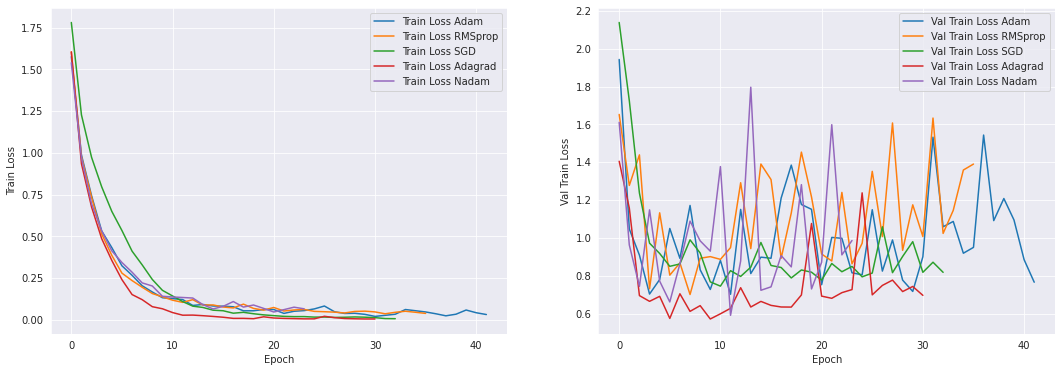

In [ ]:
def plot_history(l_hist):
    r = 1.2
    colors = ['red','blue','green']
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(1,2,figsize=(r*15,r*5)) 
  
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Train Loss')
    for i in range(len(l_hist)):
        axs[0].plot(l_hist[i]['epoch'], (l_hist[i]['loss']),label='Train Loss '+l_hist[i]['optimizer'][0],ls='-')
    axs[0].legend()
    #axs[0].set_yscale("log")

    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Val Train Loss')
    for i in range(len(l_hist)):
        axs[1].plot(l_hist[i]['epoch'], (l_hist[i]['val_loss']),label = 'Val Train Loss '+l_hist[i]['optimizer'][0],ls='-')
    axs[1].legend()
    #axs[1].set_yscale("log")

    plt.savefig('/content/drive/My Drive/Colab Notebooks/Redes Neuronales/Taller 2/output/img_cnn.png')
    plt.show()

plot_history(l_hist)